In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
Xy_numu = np.load("Xy_numu_sel5.npz")
Xy_nue = np.load("Xy_nue.sel5.npz")

In [3]:
X_numu = Xy_numu["x"]
y_numu = Xy_numu["y"]

X_nue = Xy_nue["x"]
y_nue = Xy_nue["y"]


In [4]:
X = np.vstack((X_numu, X_nue))
y = np.hstack((y_numu, y_nue))

In [5]:
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [6]:
indices = np.arange(X.shape[0])
X_train2, X_test2, y_train2, y_test2, indx_train, indx_test = train_test_split(X, y, indices, test_size=0.20, 
                                                                           random_state=42, stratify=y)

In [7]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, indx_train, indx_test = train_test_split(X, y, indices, test_size=0.20, 
                                                                           random_state=42, stratify=y)

In [8]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
    XY_SHAPE = (1, 16, 15)
    
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    xy_layer = Input(shape=XY_SHAPE, name='xy_input')
    
    zt_branch = _conv_block(zt_layer, include_dense)
    xy_branch = _conv_block(xy_layer, include_dense)
    
    # top
    if include_dense:
        x = add([zt_branch, xy_branch], name='merge_add')
    else:
        x = concatenate([zt_branch, xy_branch], name='merge_concat')
        
    x = Dense(256,activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[zt_layer, xy_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [9]:
ZT_train = np.sum(X_train, axis=(2, 3))
XY_train = np.sum(X_train, axis=(1, 4))

ZT_train = ZT_train[:, np.newaxis, ...]
XY_train = XY_train[:, np.newaxis, ...]

ZT_test = np.sum(X_test, axis=(2, 3))
XY_test = np.sum(X_test, axis=(1, 4))

ZT_test = ZT_test[:, np.newaxis, ...]
XY_test = XY_test[:, np.newaxis, ...]

In [10]:
ZT_train.shape, ZT_test.shape, XY_train.shape, XY_test.shape

((2052, 1, 75, 18), (513, 1, 75, 18), (2052, 1, 16, 15), (513, 1, 16, 15))

In [9]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'batch_size': 64, 'epochs': 30, 'verbose': 1}
history_vgg_sep = vgg_sep_model.fit([ZT_train, XY_train], to_categorical(y_train), **fitargs)


Epoch 1/30
2052/2052 [==============================] - 8s - loss: 0.6046 - acc: 0.6940     
Epoch 2/30
2052/2052 [==============================] - 7s - loss: 0.3281 - acc: 0.8743     
Epoch 3/30
2052/2052 [==============================] - 7s - loss: 0.2123 - acc: 0.9172     
Epoch 4/30
2052/2052 [==============================] - 7s - loss: 0.1699 - acc: 0.9366     
Epoch 5/30
2052/2052 [==============================] - 7s - loss: 0.1563 - acc: 0.9405     
Epoch 6/30
2052/2052 [==============================] - 7s - loss: 0.1415 - acc: 0.9527     
Epoch 7/30
2052/2052 [==============================] - 7s - loss: 0.1277 - acc: 0.9566     
Epoch 8/30
2052/2052 [==============================] - 7s - loss: 0.1288 - acc: 0.9552     
Epoch 9/30
2052/2052 [==============================] - 7s - loss: 0.1182 - acc: 0.9591     
Epoch 10/30
2052/2052 [==============================] - 7s - loss: 0.1105 - acc: 0.9635     
Epoch 11/30
2052/2052 [==============================] - 7s - loss: 0

In [10]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test,XY_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.9707602339181286)


In [11]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'batch_size': 64, 'epochs': 30, 'verbose': 1}
history_vgg_sep = vgg_sep_model.fit([ZT_train, XY_train], to_categorical(y_train), **fitargs)


Epoch 1/30
2052/2052 [==============================] - 3s - loss: 0.5523 - acc: 0.7188     
Epoch 2/30
2052/2052 [==============================] - 1s - loss: 0.3000 - acc: 0.8787     
Epoch 3/30
2052/2052 [==============================] - 1s - loss: 0.2029 - acc: 0.9176     
Epoch 4/30
2052/2052 [==============================] - 1s - loss: 0.1804 - acc: 0.9308     
Epoch 5/30
2052/2052 [==============================] - 1s - loss: 0.1612 - acc: 0.9415     
Epoch 6/30
2052/2052 [==============================] - 1s - loss: 0.1403 - acc: 0.9483     
Epoch 7/30
2052/2052 [==============================] - 1s - loss: 0.1373 - acc: 0.9508     
Epoch 8/30
2052/2052 [==============================] - 1s - loss: 0.1295 - acc: 0.9571     
Epoch 9/30
2052/2052 [==============================] - 1s - loss: 0.1298 - acc: 0.9513     
Epoch 10/30
2052/2052 [==============================] - 1s - loss: 0.1232 - acc: 0.9552     
Epoch 11/30
2052/2052 [==============================] - 1s - loss: 0

In [12]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test,XY_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.96296296296296291)


In [13]:
import root_numpy as rnp
numufile = "utilities/km3_v4_numucc_1_B.evt.aa.root"
nuefile = "utilities/km3_v4_nuecc_1.evt.JTE.aa.root"
E_numu = rnp.root2array(numufile, treename='E', branches='Evt.mc_trks.E')
type_numu = rnp.root2array(numufile, treename='E', branches = 'Evt.mc_trks.type')
E_nue = rnp.root2array(nuefile, treename='E', branches='Evt.mc_trks.E')
type_nue = rnp.root2array(nuefile, treename='E', branches = 'Evt.mc_trks.type')
E_numu_ = np.asarray([E_numu[evt][type_numu[evt]==5][0]for evt in range(E_numu.shape[0])])
E_nue_ = np.asarray([E_nue[evt][type_nue[evt]==3][0]for evt in range(E_nue.shape[0])])

In [14]:
numu_ids = np.load("numu_evt_sel_5_doms.npz")
nue_ids = np.load("nue_evt_sel_5_doms.npz")

numu_map = numu_ids["id"]
nue_map = nue_ids["id"]

E_numu_sel5 = E_numu_[numu_map]
E_nue_sel5 = E_nue_[nue_map]

Energies = np.hstack((E_numu_sel5, E_nue_sel5))

E_train, E_test = Energies[indx_train], Energies[indx_test]


In [15]:
low_E_map = np.where(np.logical_and(E_test>1e0, E_test <1e3))[0]
medium_E_map = np.where(np.logical_and(E_test>1e3, E_test<1e5))[0]
high_E_map = np.where(np.logical_and(E_test>1e5, E_test<1e8))[0]

In [24]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle


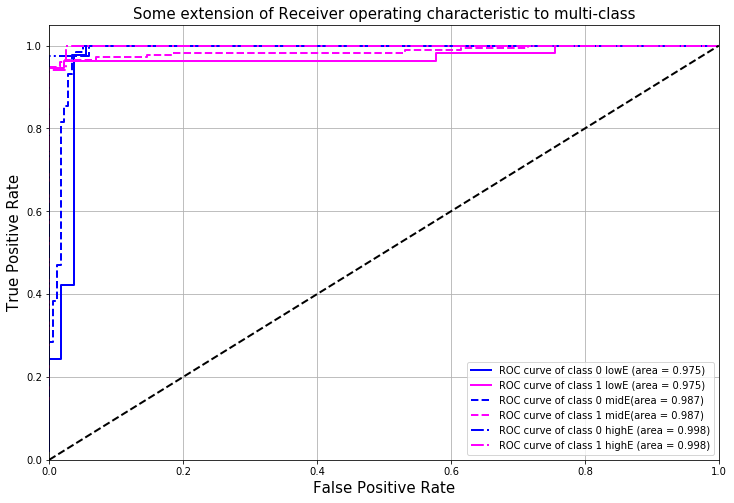

In [26]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def roc_auc_function(E_map):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(to_categorical(y_test[E_map])[:,i], predictions[E_map][:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc


fpr_low, tpr_low, roc_auc_low = roc_auc_function(low_E_map)
fpr_mid, tpr_mid, roc_auc_mid = roc_auc_function(medium_E_map)
fpr_high, tpr_high, roc_auc_high = roc_auc_function(high_E_map)
"""
def micro_macro(fpr,tpr):
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr["micro"],tpr["micro"], fpr["macro"], tpr["macro"]

fpr_m_lowE, tpr_m_lowE, fpr_M_lowE, tpr_M_lowE = micro_macro(fpr_low, tpr_low)
fpr_m_midE, tpr_m_midE, fpr_M_midE, tpr_M_midE = micro_macro(fpr_mid, tpr_mid)
fpr_m_highE, tpr_m_highE, fpr_M_highE, tpr_M_highE = micro_macro(fpr_high, tpr_high)
"""
# Plot all ROC curves
plt.figure(figsize=(12,8))
"""
plt.plot(fpr_low["micro"], tpr_low["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_low["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_mid["micro"], tpr_mid["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_mid["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_high["micro"], tpr_high["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_high["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_low["macro"], tpr_low["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_low["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.plot(fpr_mid["macro"], tpr_mid["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_mid["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.plot(fpr_high["macro"], tpr_high["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_high["macro"]),
         color='navy', linestyle=':', linewidth=4)

"""
colors = cycle(['blue', 'magenta'])
lw=2

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_low[i], tpr_low[i], color=color, lw=lw,
             label='ROC curve of class {0} lowE (area = {1:0.3f})'
             ''.format(i, roc_auc_low[i]))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_mid[i], tpr_mid[i],'--', color=color, lw=lw,
             label='ROC curve of class {0} midE(area = {1:0.3f})'
             ''.format(i, roc_auc_mid[i]))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_high[i], tpr_high[i],'-.', color=color, lw=lw,
             label='ROC curve of class {0} highE (area = {1:0.3f})'
             ''.format(i, roc_auc_high[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Some extension of Receiver operating characteristic to multi-class', size=15)
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [27]:
import root_numpy as rnp

In [28]:
fnumu = "testing_jpp/km3_v4_numuCC_1.evt.JTE.root.aa.root"
fnumu_B = "testing_jpp/km3_v4_numuCC_1_B.evt.JTE.root.aa.root"

In [35]:
dom_id = rnp.root2array(fnumu, treename="E", branches="Evt.hits.dom_id")
trig = rnp.root2array(fnumu, treename="E", branches="Evt.hits.trig")
dom_id_B = rnp.root2array(fnumu_B, treename="E", branches="Evt.hits.dom_id")
trig_B = rnp.root2array(fnumu_B, treename="E", branches="Evt.hits.trig")


In [36]:
dom_id[0][trig[0]==1].shape

(22,)

In [38]:
dom_id_B[0][trig_B[0]==1].shape

(17,)

### testing different confiurations

In [306]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='sigmoid', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
    XY_SHAPE = (1, 16, 15)
    
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    xy_layer = Input(shape=XY_SHAPE, name='xy_input')
    
    zt_branch = _conv_block(zt_layer, include_dense)
    xy_branch = _conv_block(xy_layer, include_dense)
    
    # top
    if include_dense:
        x = add([zt_branch, xy_branch], name='merge_add')
    else:
        x = concatenate([zt_branch, xy_branch], name='merge_concat')
        
    x = Dense(256,activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[zt_layer, xy_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [17]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'batch_size': 64, 'epochs': 30, 'verbose': 1, 
           'callbacks': [keras.callbacks.TensorBoard(log_dir="./logs/vgg_sep_64_3x3/", batch_size=64), 
                         keras.callbacks.ModelCheckpoint("models/vgg_numu_nue_sep_64_3x3_30epochs.hdf5")]}
history_vgg_sep = vgg_sep_model.fit([ZT_train, XY_train], to_categorical(y_train), **fitargs)


Epoch 1/30
2052/2052 [==============================] - 3s - loss: 0.5936 - acc: 0.6711     
Epoch 2/30
2052/2052 [==============================] - 1s - loss: 0.3487 - acc: 0.8723     
Epoch 3/30
2052/2052 [==============================] - 1s - loss: 0.2357 - acc: 0.9016     
Epoch 4/30
2052/2052 [==============================] - 1s - loss: 0.1914 - acc: 0.9293     
Epoch 5/30
2052/2052 [==============================] - 1s - loss: 0.1652 - acc: 0.9430     
Epoch 6/30
2052/2052 [==============================] - 1s - loss: 0.1543 - acc: 0.9440     
Epoch 7/30
2052/2052 [==============================] - 1s - loss: 0.1402 - acc: 0.9513     
Epoch 8/30
2052/2052 [==============================] - 1s - loss: 0.1399 - acc: 0.9518     
Epoch 9/30
2052/2052 [==============================] - 1s - loss: 0.1278 - acc: 0.9586     
Epoch 10/30
2052/2052 [==============================] - 1s - loss: 0.1255 - acc: 0.9596     
Epoch 11/30
2052/2052 [==============================] - 1s - loss: 0

In [10]:
vgg_sep_model= keras.models.load_model("models/vgg_numu_nue_sep_64_6x6_30epochs.hdf5")

In [18]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test,XY_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.96881091617933723)


In [43]:
wrong_class = np.where(y_test!=cls_predictions)[0].size
print(wrong_class)

16


In [50]:
fnames_test = np.asarray(["train_test_files/Xy_test"+str(i+1)+"_sel5_doms.npz"for i in range(100)])

In [15]:
from multi_files_generator import Xy_gen_ZT_XY

In [62]:
ytest = []
for i, (X_test, y_test) in enumerate(Xy_gen_ZT_XY(fnames_test)):
    ytest.append(y_test)
    if i==878:
        break
y_real = np.vstack(np.asarray(ytest))

y_real.shape

pred = vgg_sep_model.predict_generator(Xy_gen_ZT_XY(fnames_test), steps=879)
ppred = np.vstack(pred)

predicted_y = np.argmax(pred, axis=1)

file 0 : test_files/Xy_test1_sel5_doms.npz
8
file 1 : test_files/Xy_test2_sel5_doms.npz
17
file 2 : test_files/Xy_test3_sel5_doms.npz
26
file 3 : test_files/Xy_test4_sel5_doms.npz
34
file 4 : test_files/Xy_test5_sel5_doms.npz
43
file 5 : test_files/Xy_test6_sel5_doms.npz
52
file 6 : test_files/Xy_test7_sel5_doms.npz
60
file 7 : test_files/Xy_test8_sel5_doms.npz
69
file 8 : test_files/Xy_test9_sel5_doms.npz
78
file 9 : test_files/Xy_test10_sel5_doms.npz
87
file 10 : test_files/Xy_test11_sel5_doms.npz
96
file 11 : test_files/Xy_test12_sel5_doms.npz
105
file 12 : test_files/Xy_test13_sel5_doms.npz
113
file 13 : test_files/Xy_test14_sel5_doms.npz
121
file 14 : test_files/Xy_test15_sel5_doms.npz
130
file 15 : test_files/Xy_test16_sel5_doms.npz
139
file 16 : test_files/Xy_test17_sel5_doms.npz
148
file 17 : test_files/Xy_test18_sel5_doms.npz
156
file 18 : test_files/Xy_test19_sel5_doms.npz
165
file 19 : test_files/Xy_test20_sel5_doms.npz
174
file 20 : test_files/Xy_test21_sel5_doms.npz
183
fi

In [64]:
predicted_y.shape

(51818,)

In [63]:
from sklearn.metrics import accuracy_score
score = accuracy_score(np.argmax(y_real, axis=1), predicted_y)
print(score)



0.715890231194


In [56]:
score

0.71589023119379369

In [49]:
np.where(np.argmax(y_real, axis=1)!= predicted_y)[0].size

1423

In [52]:
y_real.shape

(5179, 2)

### testing generator on the "good"file

In [142]:
from export_train_test import export_train_test

In [143]:
export_train_test(403, "Xy_numu_sel5.npz", "Xy_nue.sel5.npz")

In [144]:
trainfile = []
trainfile.append("train_test_files/Xy_train404_sel5_doms.npz")

In [138]:
from get_iterations import get_n_iterations

In [256]:
get_n_iterations(fnames_test, batch_size=64)

(879, 51818)

In [151]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'steps_per_epoch': 33, 'epochs': 30, 'verbose': 1, 
           'callbacks': [keras.callbacks.TensorBoard( batch_size=64)]}#, 
                         #keras.callbacks.ModelCheckpoint("models/vgg_numu_nue_sep_64_3x3_30epochs.hdf5")]}
history_vgg_sep = vgg_sep_model.fit_generator(Xy_gen_ZT_XY(fnames_test[0], batch_size=64), **fitargs)


file 0 : train_test_files/Xy_train404_sel5_doms.npzEpoch 1/30

23/33 [===================>..........] - ETA: 1s - loss: 0.6363 - acc: 0.640633
file 0 : train_test_files/Xy_train404_sel5_doms.npz
33/33 [==============================] - 4s - loss: 0.5709 - acc: 0.6950     
Epoch 2/30
23/33 [===================>..........] - ETA: 1s - loss: 0.3586 - acc: 0.857333
file 0 : train_test_files/Xy_train404_sel5_doms.npz
33/33 [==============================] - 4s - loss: 0.3326 - acc: 0.8687     
Epoch 3/30
23/33 [===================>..........] - ETA: 1s - loss: 0.2337 - acc: 0.911733
file 0 : train_test_files/Xy_train404_sel5_doms.npz
33/33 [==============================] - 4s - loss: 0.2162 - acc: 0.9199     
Epoch 4/30
23/33 [===================>..........] - ETA: 1s - loss: 0.1696 - acc: 0.940933
file 0 : train_test_files/Xy_train404_sel5_doms.npz
33/33 [==============================] - 4s - loss: 0.1667 - acc: 0.9398     
Epoch 5/30
23/33 [===================>..........] - ETA: 1s - lo

In [147]:
testfile = []
testfile.append("train_test_files/Xy_test404_sel5_doms.npz")

get_n_iterations(testfile, batch_size=64)


(9, 513)

In [27]:
y_test2.size

513

In [30]:
np.all(y_test2==y_real)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [148]:
ytest = []
for i, (X_test, y_test) in enumerate(Xy_gen_ZT_XY(testfile)):
    ytest.append(y_test)
    if i==8:
        break
y_real = np.vstack(np.asarray(ytest))


file 0 : train_test_files/Xy_test404_sel5_doms.npz


In [152]:
pred = vgg_sep_model.predict_generator(Xy_gen_ZT_XY(testfile), steps=9)
ppred = np.vstack(pred)

predicted_y = np.argmax(pred, axis=1)

file 0 : train_test_files/Xy_test404_sel5_doms.npz
9
file 0 : train_test_files/Xy_test404_sel5_doms.npz


In [153]:
from sklearn.metrics import accuracy_score
score = accuracy_score(np.argmax(y_real, axis=1), predicted_y)
print(score)


0.968810916179


In [154]:
index = np.load("train_test_files/Xy_indx404_sel5_doms.npz")["test"]

In [155]:
numu_shape = np.load("Xy_numu_sel5.npz")["y"].shape[0]
nue_shape = np.load("Xy_nue.sel5.npz")["y"].shape[0]

In [164]:
wrong_class = index[np.where(predicted_y!=np.argmax(y_real, axis=1))]
well_class = index[np.where(predicted_y==np.argmax(y_real, axis=1))]
print("wrong classified evts: %d \nwell classified evts :%d \ntot test evts: %d"%(wrong_class.shape[0], 
                                                                                  well_class.shape[0], 
                                                                                  well_class.shape[0]+wrong_class.shape[0]))

wrong_class_numu = wrong_class[wrong_class<=numu_shape]
wrong_class_nue = wrong_class[wrong_class>numu_shape]
print("wrong class. numu evts: %d\nwrong class nue evts: %d"%(wrong_class_numu.shape[0], wrong_class_nue.shape[0]))


wrong classified evts: 16 
well classified evts :497 
tot test evts: 513
wrong class. numu evts: 16
wrong class nue evts: 0


In [167]:
np.count_nonzero(y_real)

51818

### importing the indices from the gen (to get cos_z)

In [258]:
fnames_test = np.asarray(["train_test_files/Xy_test"+str(i+1)+"_sel5_doms.npz"for i in range(100)])

In [259]:
fnames_train = np.asarray(["train_test_files/Xy_train"+str(i+1)+"_sel5_doms.npz"for i in range(100)])

In [114]:
fnames_indx = np.asarray(["train_test_files/Xy_indx"+str(i+1)+"_sel5_doms.npz"for i in range(100)])

In [115]:
indx_train = np.load(fnames_indx[0])["train"]
indx_test = np.load(fnames_indx[0])["test"]

In [165]:
ytest = []
for i, (X_test, y_test) in enumerate(Xy_gen_ZT_XY(fnames_test)):
    ytest.append(y_test)
    if i==878:
        break
y_real = np.vstack(np.asarray(ytest))

file 0 : train_test_files/Xy_test1_sel5_doms.npz
8
file 1 : train_test_files/Xy_test2_sel5_doms.npz
17
file 2 : train_test_files/Xy_test3_sel5_doms.npz
26
file 3 : train_test_files/Xy_test4_sel5_doms.npz
34
file 4 : train_test_files/Xy_test5_sel5_doms.npz
43
file 5 : train_test_files/Xy_test6_sel5_doms.npz
52
file 6 : train_test_files/Xy_test7_sel5_doms.npz
60
file 7 : train_test_files/Xy_test8_sel5_doms.npz
69
file 8 : train_test_files/Xy_test9_sel5_doms.npz
78
file 9 : train_test_files/Xy_test10_sel5_doms.npz
87
file 10 : train_test_files/Xy_test11_sel5_doms.npz
96
file 11 : train_test_files/Xy_test12_sel5_doms.npz
105
file 12 : train_test_files/Xy_test13_sel5_doms.npz
113
file 13 : train_test_files/Xy_test14_sel5_doms.npz
121
file 14 : train_test_files/Xy_test15_sel5_doms.npz
130
file 15 : train_test_files/Xy_test16_sel5_doms.npz
139
file 16 : train_test_files/Xy_test17_sel5_doms.npz
148
file 17 : train_test_files/Xy_test18_sel5_doms.npz
156
file 18 : train_test_files/Xy_test19_sel5

In [168]:
y_real.shape

(51818, 2)

In [169]:
pred = vgg_sep_model.predict_generator(Xy_gen_ZT_XY(fnames_test), steps=879)
ppred = np.vstack(pred)

predicted_y = np.argmax(pred, axis=1)

file 0 : train_test_files/Xy_test1_sel5_doms.npz
8
file 1 : train_test_files/Xy_test2_sel5_doms.npz
17
file 2 : train_test_files/Xy_test3_sel5_doms.npz
26
file 3 : train_test_files/Xy_test4_sel5_doms.npz
34
file 4 : train_test_files/Xy_test5_sel5_doms.npz
43
file 5 : train_test_files/Xy_test6_sel5_doms.npz
52
file 6 : train_test_files/Xy_test7_sel5_doms.npz
60
file 7 : train_test_files/Xy_test8_sel5_doms.npz
69
file 8 : train_test_files/Xy_test9_sel5_doms.npz
78
file 9 : train_test_files/Xy_test10_sel5_doms.npz
87
file 10 : train_test_files/Xy_test11_sel5_doms.npz
96
file 11 : train_test_files/Xy_test12_sel5_doms.npz
105
file 12 : train_test_files/Xy_test13_sel5_doms.npz
113
file 13 : train_test_files/Xy_test14_sel5_doms.npz
121
file 14 : train_test_files/Xy_test15_sel5_doms.npz
130
file 15 : train_test_files/Xy_test16_sel5_doms.npz
139
file 16 : train_test_files/Xy_test17_sel5_doms.npz
148
file 17 : train_test_files/Xy_test18_sel5_doms.npz
156
file 18 : train_test_files/Xy_test19_sel5

In [170]:
predicted_y.shape

(51818,)

In [171]:
from sklearn.metrics import accuracy_score
score = accuracy_score(np.argmax(y_real, axis=1), predicted_y)
print("Accuracy score: ", score)

('Accuracy score: ', 0.72204639314523911)


In [232]:
wrong = np.where(predicted_y!=np.argmax(y_real, axis=1))[0]

In [189]:
np.count_nonzero(np.argmax(y_real, axis=1))

30469

In [172]:
wrong_class = indx_test[np.where(predicted_y!=np.argmax(y_real, axis=1))]

IndexError: index 510 is out of bounds for axis 1 with size 508

In [180]:
indices_test = []
for i in range(100):
    indices_test.append(np.load(fnames_indx[i])["test"])
indices_test = np.asarray(indices_test)

In [184]:
np.hstack(indices_test).shape

(51818,)

In [185]:
wrong_class_multifiles = np.hstack(indices_test)[np.where(predicted_y!=np.argmax(y_real, axis=1))[0]]

In [124]:
numu_shape = 1472
nue_shape = 1065
wrong_class_numu = wrong_class[wrong_class<=numu_shape]
wrong_class_nue = wrong_class[wrong_class>numu_shape]
print(wrong_class.shape, wrong_class_numu.shape, wrong_class_nue.shape)

((162,), (3,), (159,))


In [71]:
fnames_numu_dirz = np.asarray(["Xy_files/numu_"+str(i+1)+"_sel5_dir_z.npz"for i in range(100)])
fnames_nue_dirz = np.asarray(["Xy_files/nue_"+str(i+1)+"_sel5_dir_z.npz"for i in range(100)])

In [72]:
fnames_numu_dirz

array(['Xy_files/numu_1_sel5_dir_z.npz', 'Xy_files/numu_2_sel5_dir_z.npz',
       'Xy_files/numu_3_sel5_dir_z.npz', 'Xy_files/numu_4_sel5_dir_z.npz',
       'Xy_files/numu_5_sel5_dir_z.npz', 'Xy_files/numu_6_sel5_dir_z.npz',
       'Xy_files/numu_7_sel5_dir_z.npz', 'Xy_files/numu_8_sel5_dir_z.npz',
       'Xy_files/numu_9_sel5_dir_z.npz', 'Xy_files/numu_10_sel5_dir_z.npz',
       'Xy_files/numu_11_sel5_dir_z.npz',
       'Xy_files/numu_12_sel5_dir_z.npz',
       'Xy_files/numu_13_sel5_dir_z.npz',
       'Xy_files/numu_14_sel5_dir_z.npz',
       'Xy_files/numu_15_sel5_dir_z.npz',
       'Xy_files/numu_16_sel5_dir_z.npz',
       'Xy_files/numu_17_sel5_dir_z.npz',
       'Xy_files/numu_18_sel5_dir_z.npz',
       'Xy_files/numu_19_sel5_dir_z.npz',
       'Xy_files/numu_20_sel5_dir_z.npz',
       'Xy_files/numu_21_sel5_dir_z.npz',
       'Xy_files/numu_22_sel5_dir_z.npz',
       'Xy_files/numu_23_sel5_dir_z.npz',
       'Xy_files/numu_24_sel5_dir_z.npz',
       'Xy_files/numu_25_sel5_dir_z.

In [76]:
z_numu = np.load(fnames_numu_dirz[0])["z"]
z_nue = np.load(fnames_nue_dirz[0])["z"]

In [77]:
z_numu.shape, z_nue.shape

((1472,), (1065,))

In [108]:
np.hstack((z_numu, z_nue)).shape

(2537,)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([-0.291675 , -0.1826902, -0.0737054,  0.0352794,  0.1442642,
         0.253249 ,  0.3622338,  0.4712186,  0.5802034,  0.6891882,
         0.798173 ]),
 <a list of 10 Patch objects>)

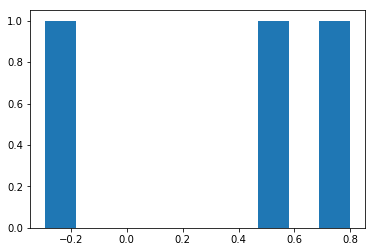

In [127]:
plt.hist(np.hstack((z_numu, z_nue))[wrong_class_numu])

In [98]:
np.shape(indx_test)[0]+np.shape(indx_train)[0]

2537

In [106]:
x = np.load("train_test_files/Xy_train1_sel5_doms.npz")["x"]

In [112]:
np.unique(x).shape

(2,)

In [113]:
x.shape

(2029, 75, 16, 15, 18)

In [199]:
fnames_numu_dirz = np.asarray(["Xy_files/numu_"+str(i+1)+"_sel5_dir_z.npz"for i in range(100)])
fnames_nue_dirz = np.asarray(["Xy_files/nue_"+str(i+1)+"_sel5_dir_z.npz"for i in range(100)])

In [272]:
dir_z_test = []
for i in range(1):
    numu_dir_z = np.load(fnames_numu_dirz[i])["z"]
    nue_dir_z = np.load(fnames_nue_dirz[i])["z"]
    #print(numu_dir_z.shape[0], nue_dir_z.shape[0])
    dir_z = np.hstack((numu_dir_z, nue_dir_z))
    #print(dir_z.shape[0])
    indx_test = np.load(fnames_indx[i])["test"]
    dir_z_test.append(dir_z[indx_test])
dir_z_test = np.asarray(dir_z_test)    
    

In [273]:
dirz_test = np.hstack(dir_z_test)

In [274]:
dirz_test.shape

(508,)

(array([ 1355.,  1391.,  1384.,  1396.,  1388.,  1393.,  1521.,  1512.,
         1520.,  1543.]),
 array([ -9.99872000e-01,  -7.99902400e-01,  -5.99932800e-01,
         -3.99963200e-01,  -1.99993600e-01,  -2.40000000e-05,
          1.99945600e-01,   3.99915200e-01,   5.99884800e-01,
          7.99854400e-01,   9.99824000e-01]),
 <a list of 10 Patch objects>)

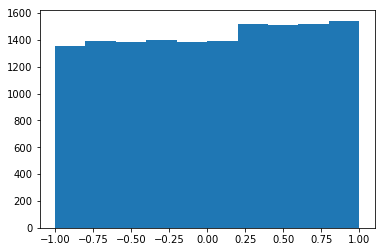

In [235]:
plt.hist(dirz_test[wrong])

In [236]:
wrong.shape

(14403,)

In [237]:
i=[]
j=[]
k=[]
for ii,x in enumerate(range(-300,1100,90)):
    for jj,y in enumerate(np.arange(-550,550, 45*np.sqrt(3))):
        for kk,z in enumerate(range(98,712,36)):
            i.append(ii)
            j.append(jj)
            k.append(kk)
        x-= 45
l_i = np.asarray(i)
l_j = np.asarray(j)
l_k = np.asarray(k)


arr = []
for i,j,k in zip(l_i,l_j,l_k):
    arr.append((i,j,k))
lol = np.asarray(arr)


In [242]:
X = np.load(fnames_train[0])["x"]

In [266]:

def plot_x_evt(evt):
    ggg = np.sum(X_test[evt], axis=0)
    hhh = np.nonzero(ggg)
    return ax.scatter(hhh[0],hhh[1],hhh[2], alpha=0.9,label="evt {}".format(evt))


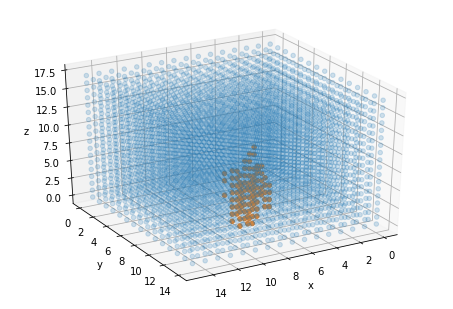

In [250]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
#ax.scatter(l_i, l_j, l_k , alpha=0.3)
ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)
#ax.scatter(doms["x"], doms["y"], doms["z"], color="grey", alpha=0.02)
plot_x_evt(300)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()



In [ ]:
fnames_train

In [260]:
X_train = np.load(fnames_train[0])["x"]
X_test = np.load(fnames_test[0])["x"]
y_train = np.load(fnames_train[0])["y"]
y_test = np.load(fnames_test[0])["y"]

In [261]:
ZT_train = np.sum(X_train, axis=(2, 3))
XY_train = np.sum(X_train, axis=(1, 4))

ZT_train = ZT_train[:, np.newaxis, ...]
XY_train = XY_train[:, np.newaxis, ...]

ZT_test = np.sum(X_test, axis=(2, 3))
XY_test = np.sum(X_test, axis=(1, 4))

ZT_test = ZT_test[:, np.newaxis, ...]
XY_test = XY_test[:, np.newaxis, ...]

In [307]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'batch_size': 64, 'epochs': 30, 'verbose': 1, 
           'callbacks': [keras.callbacks.TensorBoard(log_dir="./logs/vgg_sep_64_3x3/", batch_size=64)]}#, 
                         #keras.callbacks.ModelCheckpoint("models/vgg_numu_nue_sep_64_3x3_30epochs.hdf5")]}
history_vgg_sep = vgg_sep_model.fit([ZT_train, XY_train], to_categorical(y_train), **fitargs)

Epoch 1/30
2029/2029 [==============================] - 1s - loss: 0.6823 - acc: 0.5752     
Epoch 2/30
2029/2029 [==============================] - 1s - loss: 0.6812 - acc: 0.5791     
Epoch 3/30
2029/2029 [==============================] - 1s - loss: 0.6829 - acc: 0.5791     
Epoch 4/30
2029/2029 [==============================] - 1s - loss: 0.6790 - acc: 0.5791     
Epoch 5/30
2029/2029 [==============================] - 1s - loss: 0.6687 - acc: 0.6136     
Epoch 6/30
2029/2029 [==============================] - 1s - loss: 0.6118 - acc: 0.6994     
Epoch 7/30
2029/2029 [==============================] - 1s - loss: 0.5030 - acc: 0.7693     
Epoch 8/30
2029/2029 [==============================] - 1s - loss: 0.3998 - acc: 0.8260     
Epoch 9/30
2029/2029 [==============================] - 1s - loss: 0.3648 - acc: 0.8369     
Epoch 10/30
2029/2029 [==============================] - 1s - loss: 0.3046 - acc: 0.8743     
Epoch 11/30
2029/2029 [==============================] - 1s - loss: 0

In [264]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test,XY_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.91141732283464572)


In [278]:
wrong_class = np.where(y_test!=cls_predictions)[0]
print(wrong_class)

[  4  28  37  39  49  68  71  74  88 124 140 148 167 170 195 202 207 217
 226 230 249 268 278 295 305 312 341 345 364 372 375 384 393 407 422 424
 450 458 471 478 483 490 494 503 505]


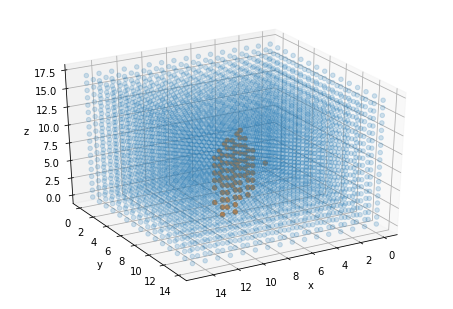

In [269]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)

plot_x_evt(37)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()


In [ ]:
dir_z = np.load("Xy_files/numu_1_sel5_dir_z.npz)

In [279]:
wrong_class

array([  4,  28,  37,  39,  49,  68,  71,  74,  88, 124, 140, 148, 167,
       170, 195, 202, 207, 217, 226, 230, 249, 268, 278, 295, 305, 312,
       341, 345, 364, 372, 375, 384, 393, 407, 422, 424, 450, 458, 471,
       478, 483, 490, 494, 503, 505])

In [284]:
dir_z_test[0][wrong_class]

array([ 0.417277,  0.857691, -0.31963 ,  0.124185,  0.235239,  0.524144,
        0.992681,  0.654783, -0.609141,  0.930152,  0.565298,  0.78543 ,
        0.316648, -0.65361 ,  0.883244, -0.257028, -0.892559,  0.756183,
       -0.748483, -0.728937, -0.839882,  0.227931, -0.587865, -0.267899,
        0.747777, -0.291675,  0.026221, -0.786922, -0.022024, -0.965638,
       -0.933759, -0.290189, -0.465254, -0.106168,  0.869185, -0.754712,
        0.798173, -0.629383,  0.492218, -0.63161 , -0.461368,  0.789222,
       -0.518842,  0.14008 ,  0.840602])

In [285]:
X_test.shape

(508, 75, 16, 15, 18)

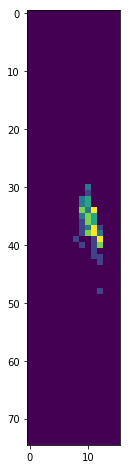

In [303]:
plt.figure(figsize=(4,8))
plt.imshow(np.sum(X_test[wrong_class][2], axis=(2,3)))

In [305]:
np.nonznp.sum(X_test[wrong_class][2], axis=(2,3))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint64)

###  testing new generator

In [1]:
import numpy as np
fnames_test = np.asarray(["train_test_files/Xy_test"+str(i+1)+"_sel5_doms.npz"for i in range(100)])
fnames_train = np.asarray(["train_test_files/Xy_train"+str(i+1)+"_sel5_doms.npz"for i in range(100)])
fnames_indx = np.asarray(["train_test_files/Xy_indx"+str(i+1)+"_sel5_doms.npz"for i in range(100)])
from multi_files_generator import Xy_gen_ZT_XY_cont as generator


Using TensorFlow backend.


In [19]:
from keras.utils import to_categorical
from get_iterations import get_n_iterations
steps_per_epoch, n_events = get_n_iterations(fnames_train)
print(steps_per_epoch, n_events)

(3236, 207061)


In [20]:
from get_iterations import get_class_weights
get_class_weights(fnames_train)

array([ 1.20312954,  0.85555326])

In [21]:
cls_weights = {i:v for i, v in enumerate(get_class_weights(fnames_train))}

In [22]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
    XY_SHAPE = (1, 16, 15)
    
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    xy_layer = Input(shape=XY_SHAPE, name='xy_input')
    
    zt_branch = _conv_block(zt_layer)#, include_dense)
    xy_branch = _conv_block(xy_layer)#, include_dense)
    
    # top
    if include_dense:
        x = add([zt_branch, xy_branch], name='merge_add')
    else:
        x = concatenate([zt_branch, xy_branch], name='merge_concat')
        
    x = Dense(256,activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[zt_layer, xy_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [23]:
from keras.backend import clear_session
clear_session()

In [24]:
import keras

b_size = 64
epochs = 40
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 
           'class_weight' : cls_weights,
           'callbacks': [#keras.callbacks.TensorBoard(batch_size=b_size), 
                         keras.callbacks.ModelCheckpoint("models/vgg_sep_numu_nue_cls_weighted_100files_"+str(b_size)+"_3x3_"+str(epochs)+"epochs.hdf5")]}
history_vgg_sep = vgg_sep_model.fit_generator(generator(fnames_train, batch_size=b_size), **fitargs)


Epoch 1/40
file 1 : train_test_files/Xy_train1_sel5_doms.npz
3236/3236 [==============================] - 433s - loss: 0.2250 - acc: 0.9117   
Epoch 2/40
 635/3236 [====>.........................] - ETA: 350s - loss: 0.2012 - acc: 0.9226file 21 : train_test_files/Xy_train21_sel5_doms.npz


2610/3236 [=======================>......] - ETA: 84s - loss: 0.1975 - acc: 0.9234file 82 : train_test_files/Xy_train82_sel5_doms.npz


3236/3236 [==============================] - 434s - loss: 0.1963 - acc: 0.9238   
Epoch 3/40
3236/3236 [==============================] - 436s - loss: 0.1897 - acc: 0.9265   
Epoch 4/40
  21/3236 [..............................] - ETA: 548s - loss: 0.1731 - acc: 0.9382file 2 : train_test_files/Xy_train2_sel5_doms.npz


1994/3236 [=================>............] - ETA: 168s - loss: 0.1867 - acc: 0.9276file 63 : train_test_files/Xy_train63_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.1854 - acc: 0.9281   
Epoch 5/40
2674/3236 [=======================>......] - ETA: 76s - loss: 0.1827 - acc: 0.9290file 84 : train_test_files/Xy_train84_sel5_doms.npz


3236/3236 [==============================] - 437s - loss: 0.1818 - acc: 0.9294   
Epoch 6/40
3236/3236 [==============================] - 438s - loss: 0.1787 - acc: 0.9308   
Epoch 7/40
  87/3236 [..............................] - ETA: 455s - loss: 0.1779 - acc: 0.9301file 4 : train_test_files/Xy_train4_sel5_doms.npz


2058/3236 [==================>...........] - ETA: 160s - loss: 0.1769 - acc: 0.9314file 65 : train_test_files/Xy_train65_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.1756 - acc: 0.9320   
Epoch 8/40
2739/3236 [========================>.....] - ETA: 67s - loss: 0.1730 - acc: 0.9329file 86 : train_test_files/Xy_train86_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.1724 - acc: 0.9332   
Epoch 9/40
3236/3236 [==============================] - 439s - loss: 0.1690 - acc: 0.9344   
Epoch 10/40
 151/3236 [>.............................] - ETA: 434s - loss: 0.1681 - acc: 0.9343file 6 : train_test_files/Xy_train6_sel5_doms.npz


2123/3236 [==================>...........] - ETA: 151s - loss: 0.1669 - acc: 0.9352file 67 : train_test_files/Xy_train67_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.1654 - acc: 0.9359   
Epoch 11/40
2803/3236 [========================>.....] - ETA: 58s - loss: 0.1620 - acc: 0.9373file 88 : train_test_files/Xy_train88_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.1614 - acc: 0.9376   
Epoch 12/40
3236/3236 [==============================] - 439s - loss: 0.1570 - acc: 0.9395   
Epoch 13/40
 215/3236 [>.............................] - ETA: 422s - loss: 0.1563 - acc: 0.9394file 8 : train_test_files/Xy_train8_sel5_doms.npz


2189/3236 [===================>..........] - ETA: 142s - loss: 0.1541 - acc: 0.9408file 69 : train_test_files/Xy_train69_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.1521 - acc: 0.9415   
Epoch 14/40
2867/3236 [=========================>....] - ETA: 50s - loss: 0.1480 - acc: 0.9432file 90 : train_test_files/Xy_train90_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.1468 - acc: 0.9436   
Epoch 15/40
3236/3236 [==============================] - 438s - loss: 0.1411 - acc: 0.9458   
Epoch 16/40
 280/3236 [=>............................] - ETA: 412s - loss: 0.1409 - acc: 0.9456file 10 : train_test_files/Xy_train10_sel5_doms.npz


2253/3236 [===================>..........] - ETA: 133s - loss: 0.1372 - acc: 0.9475file 71 : train_test_files/Xy_train71_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.1350 - acc: 0.9483   
Epoch 17/40
2932/3236 [==========================>...] - ETA: 41s - loss: 0.1299 - acc: 0.9496file 92 : train_test_files/Xy_train92_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.1290 - acc: 0.9500   
Epoch 18/40
3236/3236 [==============================] - 438s - loss: 0.1227 - acc: 0.9527   
Epoch 19/40
 345/3236 [==>...........................] - ETA: 399s - loss: 0.1235 - acc: 0.9521file 12 : train_test_files/Xy_train12_sel5_doms.npz


2318/3236 [====================>.........] - ETA: 125s - loss: 0.1182 - acc: 0.9541file 73 : train_test_files/Xy_train73_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.1167 - acc: 0.9548   
Epoch 20/40
2998/3236 [==========================>...] - ETA: 32s - loss: 0.1118 - acc: 0.9565file 94 : train_test_files/Xy_train94_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.1114 - acc: 0.9568   
Epoch 21/40
3236/3236 [==============================] - 439s - loss: 0.1062 - acc: 0.9585   
Epoch 22/40
 409/3236 [==>...........................] - ETA: 390s - loss: 0.1077 - acc: 0.9588file 14 : train_test_files/Xy_train14_sel5_doms.npz


2382/3236 [=====================>........] - ETA: 116s - loss: 0.1021 - acc: 0.9598file 75 : train_test_files/Xy_train75_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.1011 - acc: 0.9601   
Epoch 23/40
3063/3236 [===========================>..] - ETA: 23s - loss: 0.0966 - acc: 0.9612file 96 : train_test_files/Xy_train96_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.0965 - acc: 0.9612   
Epoch 24/40
3236/3236 [==============================] - 439s - loss: 0.0922 - acc: 0.9629   
Epoch 25/40
 473/3236 [===>..........................] - ETA: 381s - loss: 0.0942 - acc: 0.9622file 16 : train_test_files/Xy_train16_sel5_doms.npz


2447/3236 [=====================>........] - ETA: 107s - loss: 0.0879 - acc: 0.9645file 77 : train_test_files/Xy_train77_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.0876 - acc: 0.9646   
Epoch 26/40
3128/3236 [===========================>..] - ETA: 14s - loss: 0.0839 - acc: 0.9662file 98 : train_test_files/Xy_train98_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.0840 - acc: 0.9662   
Epoch 27/40
3236/3236 [==============================] - 439s - loss: 0.0800 - acc: 0.9673   
Epoch 28/40
 538/3236 [===>..........................] - ETA: 370s - loss: 0.0847 - acc: 0.9657file 18 : train_test_files/Xy_train18_sel5_doms.npz


2512/3236 [======================>.......] - ETA: 98s - loss: 0.0771 - acc: 0.9686file 79 : train_test_files/Xy_train79_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.0766 - acc: 0.9687   
Epoch 29/40
3193/3236 [============================>.] - ETA: 5s - loss: 0.0730 - acc: 0.9704file 100 : train_test_files/Xy_train100_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.0730 - acc: 0.9703   
Epoch 30/40
3236/3236 [==============================] - 440s - loss: 0.0701 - acc: 0.9712   
Epoch 31/40
 602/3236 [====>.........................] - ETA: 359s - loss: 0.0733 - acc: 0.9706file 20 : train_test_files/Xy_train20_sel5_doms.npz


2577/3236 [======================>.......] - ETA: 89s - loss: 0.0676 - acc: 0.9729file 81 : train_test_files/Xy_train81_sel5_doms.npz


3236/3236 [==============================] - 437s - loss: 0.0675 - acc: 0.9729   
Epoch 32/40
3236/3236 [==============================] - 439s - loss: 0.0641 - acc: 0.9742   
Epoch 33/40


1961/3236 [=================>............] - ETA: 173s - loss: 0.0627 - acc: 0.9747file 62 : train_test_files/Xy_train62_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.0612 - acc: 0.9753   
Epoch 34/40
2642/3236 [=======================>......] - ETA: 80s - loss: 0.0604 - acc: 0.9756file 83 : train_test_files/Xy_train83_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.0602 - acc: 0.9757   
Epoch 35/40
3236/3236 [==============================] - 439s - loss: 0.0569 - acc: 0.9770   
Epoch 36/40
  54/3236 [..............................] - ETA: 473s - loss: 0.0676 - acc: 0.9696file 3 : train_test_files/Xy_train3_sel5_doms.npz


2027/3236 [=================>............] - ETA: 164s - loss: 0.0546 - acc: 0.9780file 64 : train_test_files/Xy_train64_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.0538 - acc: 0.9785   
Epoch 37/40
2707/3236 [========================>.....] - ETA: 71s - loss: 0.0514 - acc: 0.9798file 85 : train_test_files/Xy_train85_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.0511 - acc: 0.9798   
Epoch 38/40
3236/3236 [==============================] - 438s - loss: 0.0490 - acc: 0.9806   
Epoch 39/40
 119/3236 [>.............................] - ETA: 440s - loss: 0.0615 - acc: 0.9756file 5 : train_test_files/Xy_train5_sel5_doms.npz


2091/3236 [==================>...........] - ETA: 155s - loss: 0.0481 - acc: 0.9810file 66 : train_test_files/Xy_train66_sel5_doms.npz


3236/3236 [==============================] - 439s - loss: 0.0473 - acc: 0.9814   
Epoch 40/40
2772/3236 [========================>.....] - ETA: 63s - loss: 0.0465 - acc: 0.9820file 87 : train_test_files/Xy_train87_sel5_doms.npz


3236/3236 [==============================] - 438s - loss: 0.0466 - acc: 0.9819   


In [8]:
prediction_step, n_events = get_n_iterations(fnames_test)
print(prediction_step, n_events)

(81, 5179)


In [16]:
ytest = []
for i, (X_test, y_test) in enumerate(generator(fnames_test)):
    ytest.append(y_test)
    if i==prediction_step-1:
        break
y_real = np.vstack(np.asarray(ytest))

print(y_real.shape)

pred = vgg_sep_model.predict_generator(generator(fnames_test), steps=prediction_step)
ppred = np.vstack(pred)

predicted_y = np.argmax(pred, axis=1)
print(predicted_y.shape)

file 1 : train_test_files/Xy_test1_sel5_doms.npz
file 2 : train_test_files/Xy_test2_sel5_doms.npz
file 3 : train_test_files/Xy_test3_sel5_doms.npz
file 4 : train_test_files/Xy_test4_sel5_doms.npz
file 5 : train_test_files/Xy_test5_sel5_doms.npz
file 6 : train_test_files/Xy_test6_sel5_doms.npz
file 7 : train_test_files/Xy_test7_sel5_doms.npz
file 8 : train_test_files/Xy_test8_sel5_doms.npz
file 9 : train_test_files/Xy_test9_sel5_doms.npz
file 10 : train_test_files/Xy_test10_sel5_doms.npz
(5179, 2)
file 1 : train_test_files/Xy_test1_sel5_doms.npz
file 2 : train_test_files/Xy_test2_sel5_doms.npz
file 3 : train_test_files/Xy_test3_sel5_doms.npz
file 4 : train_test_files/Xy_test4_sel5_doms.npz
file 5 : train_test_files/Xy_test5_sel5_doms.npz
file 6 : train_test_files/Xy_test6_sel5_doms.npz
file 7 : train_test_files/Xy_test7_sel5_doms.npz
file 8 : train_test_files/Xy_test8_sel5_doms.npz
file 9 : train_test_files/Xy_test9_sel5_doms.npz
file 10 : train_test_files/Xy_test10_sel5_doms.npz
file 1

In [17]:
from sklearn.metrics import accuracy_score
score = accuracy_score(np.argmax(y_real, axis=1), predicted_y)
print(score)

0.916972388492
